In [1]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')  
import warnings
warnings.filterwarnings('ignore')

/var/folders/_t/qlzp5l894v16vmr8m_81x5x80000gn/T/ipykernel_49240/2489172623.py:3: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


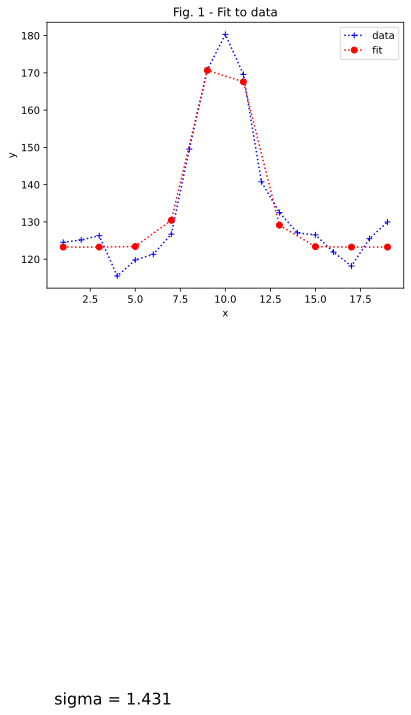

sigma = 1.431


In [2]:

import numpy as np 
import matplotlib.pyplot as plt

#import a file from /Users/baljyot/Downloads/Values.csv
data = np.loadtxt('/Users/baljyot/Downloads/Values.csv', delimiter=',',skiprows=2)
#fit a gaussian to the data
from scipy.optimize import curve_fit
def gaussian(x, a, x0, sigma, offset):
    return a*np.exp(-(x-x0)**2/(2*sigma**2)) + offset
popt,pcov = curve_fit(gaussian,data[:,0],data[:,1],p0=[2,10,1,120])
#plot the data and the fit
plt.plot(data[:,0],data[:,1],'b+:',label='data')
#over the range of the data plot the fit
x = np.linspace(min(data[:,0]),max(data[:,0]),10)
plt.plot(x,gaussian(x,*popt),'ro:',label='fit')
#on the plot print the sigma value
plt.text(0.5, 0.5, 'sigma = %5.3f' % popt[2], fontsize=16)

plt.legend()
plt.title('Fig. 1 - Fit to data')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

print("sigma = %5.3f" % popt[2])


In [3]:
#load a tif file with 5000 frames
import tifffile as tiff
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


#load the tif file
data = tiff.imread('/Users/baljyot/Documents/laco_laci_ez_1_seg.tif')
print(data.shape)



(5000, 290, 292)


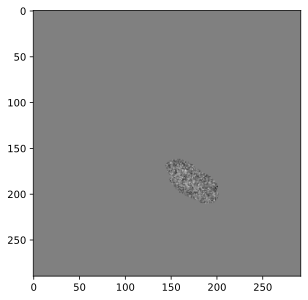

In [4]:
#plot the first frame
plt.imshow(data[0,:,:],cmap='gray')
plt.show()


In [5]:
#threshold all the frames and plot the first frame
data_th = data > 150
#make the values integers
data_th = data_th.astype(int)
#check the intensity values of the first frame
print(data_th[0,0:10,0:10])


[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]


1


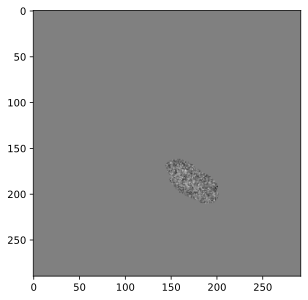

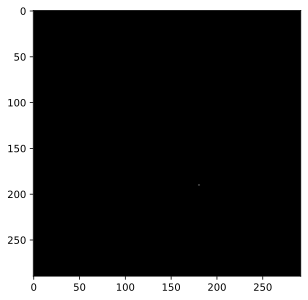

In [6]:
#find regions of interest using regionprops
#before using regionprops, dilate the image to make the regions more visible
from skimage import measure
#use labels to connect the regions
labels_th = measure.label(data_th[0,:,:],connectivity=2,background=0)
regions = measure.regionprops(labels_th)
print(len(regions))

#plot the 126th frame with the regions of interest
plt.imshow(data[0,:,:],cmap='gray')
plt.show()

#plot the regions of interest along with the original image
fig, ax = plt.subplots()
ax.imshow(data_th[0,:,:], cmap=plt.cm.gray)
for props in regions:
    #ignore regions with only 2 pixels
    if props.area > 2:
        #plot the regions with a red boundary
        y0, x0 = props.centroid
        ax.plot(x0, y0, 'ro', fillstyle='none')
plt.show()





In [7]:
#apply this to the entire stack of images
#find the centroids of all the regions of interest
import pandas as pd
#make a dataframe to store the centroids
df = pd.DataFrame(columns=['frame','x','y'])
#loop over all the frames
for i in range(0,data.shape[0]):
    #find the regions of interest
    labels_th = measure.label(data_th[i,:,:],connectivity=2,background=0)
    regions = measure.regionprops(labels_th)
    #loop over all the regions of interest
    for props in regions:
        #ignore regions with only 2 pixels
        if props.area > 2:
                
            y0, x0 = props.centroid
            #use concat to add the new row to the dataframe
            df = pd.concat([df,pd.DataFrame([[i,x0,y0]],columns=['frame','x','y'])])


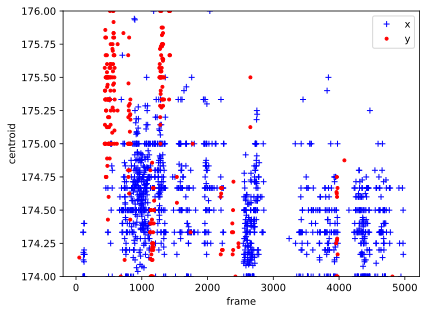

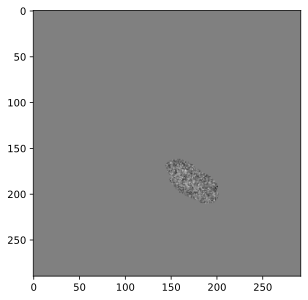

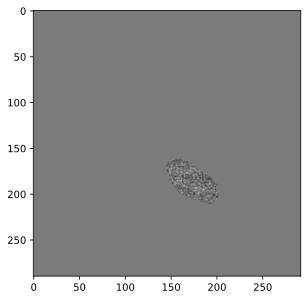

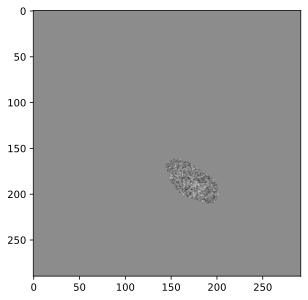

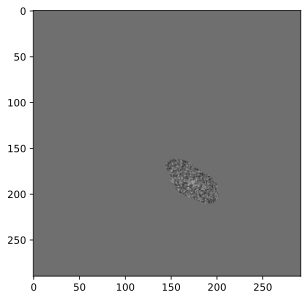

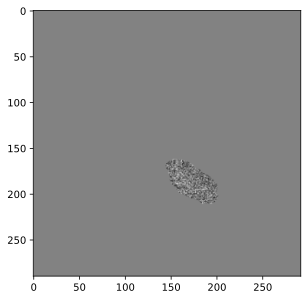

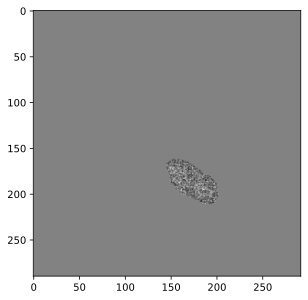

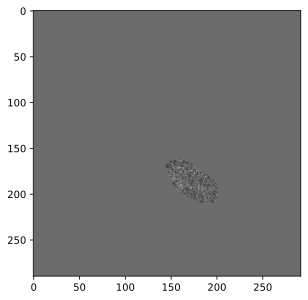

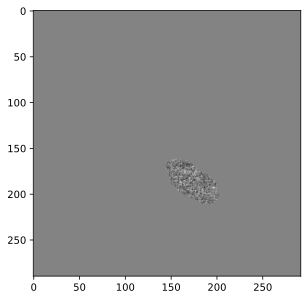

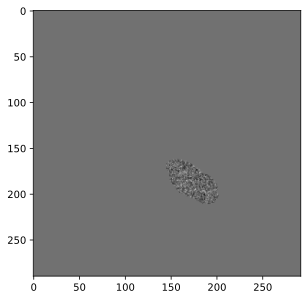

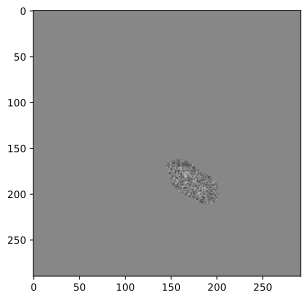

In [52]:
#plot the centroids as a function of time
plt.plot(df['frame'],df['x'],'b+',label='x')
plt.plot(df['frame'],df['y'],'r.',label='y')
plt.legend()
plt.xlabel('frame')
plt.ylabel('centroid')
plt.ylim(174,176)
plt.show()

#for the first 10 frames plot the centroids along with the original image
for i in range(0,10):
    fig, ax = plt.subplots()
    ax.imshow(data[i,:,:], cmap=plt.cm.gray)
    #plot the centroids for the ith frames using df and the frame number
    ax.plot(df[df['frame']==i]['x'], df[df['frame']==i]['y'], 'ro', fillstyle='none')
    
    plt.show()


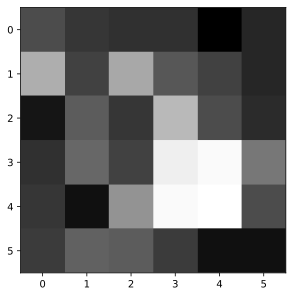

In [9]:
#allow inline plotting
%matplotlib inline
#for each region found in frame 126, create a 3x3 pixel mask around the centroid and display the original image
#find the ceteroid of the region of interest from the df 
x0 = df[(df['frame']==126) & (df['x']>0) & (df['y']>0)]['x'].values[0]
y0 = df[(df['frame']==126) & (df['x']>0) & (df['y']>0)]['y'].values[0]
#make a mask around the centroid
#subtract the background value we thresholded before
mask = data[126,int(y0-3):int(y0+3),int(x0-3):int(x0+3)]
#plot the mask
plt.imshow(mask-100,cmap='gray')
plt.show()



I: 164.000, x0: 174.400, y0: 193.200, sigma_x: 1.000, sigma_y: 1.000, offset: 133.889


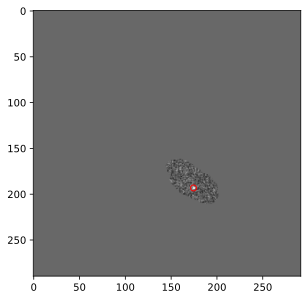

In [10]:
#fit a 2D gaussian to the mask
#make a meshgrid of the size of the mask
x = np.arange(0,6,1)
y = np.arange(0,6,1)
X,Y = np.meshgrid(x,y)
#flatten the mask
Z = mask.ravel()
X,Y = X.ravel(),Y.ravel()
#fit a 2D gaussian to the mask
def gaussian2D(XY, a, x0, y0, sigma_x, sigma_y, offset):
    (x,y) = XY
    return a*np.exp(-(x-x0)**2/(2*sigma_x**2) - (y-y0)**2/(2*sigma_y**2)) + offset
#use the maximum value of the mask as the initial guess for the amplitude, the centroid as the initial guess for the center, and 1 for the initial guess for the sigma
popt,pcov = curve_fit(gaussian2D,(X,Y),Z,p0=[np.max(Z),df[(df['frame']==126) & (df['x']>0) & (df['y']>0)]['x'].values[0],df[(df['frame']==126) & (df['x']>0) & (df['y']>0)]['y'].values[0],1,1,0])

print("I: %5.3f, x0: %5.3f, y0: %5.3f, sigma_x: %5.3f, sigma_y: %5.3f, offset: %5.3f" % tuple(popt))

#plot the original image with the x0 and y0 values as a red cross
plt.imshow(data[126,:,:],cmap='gray')
plt.plot(df[(df['frame']==126) & (df['x']>0) & (df['y']>0)]['x'], df[(df['frame']==126) & (df['x']>0) & (df['y']>0)]['y'], 'ro', fillstyle='none')
plt.show()



In [11]:
#Lets apply this to all the frames using the already made dataframe
#for each frame find the centroid of each region of interest and make a mask around it and fit a 2D gaussian to it

#store the fit parameter data in a dataframe
df_fit = pd.DataFrame(columns=['frame','I','x0','y0','sigma_x','sigma_y','offset'])

for i in range(data.shape[0]):
    #find all the x0,y0 values for the ith frame 
    x0 = df[(df['frame']==i) & (df['x']>0) & (df['y']>0)]['x'].values
    y0 = df[(df['frame']==i) & (df['x']>0) & (df['y']>0)]['y'].values
    #loop over all the regions of interest
    for j in range(len(x0)):
        #create a 3x3 mask around the centroid
        mask = data[i,int(y0[j]-3):int(y0[j]+3),int(x0[j]-3):int(x0[j]+3)]
        #fit a 2D gaussian to the mask
        #make a meshgrid of the size of the mask
        x = np.arange(0,6,1)
        y = np.arange(0,6,1)
        X,Y = np.meshgrid(x,y)
        #flatten the mask
        Z = mask.ravel()
        X,Y = X.ravel(),Y.ravel()
        #fit a 2D gaussian to the mask which is the same as before
        popt,pcov = curve_fit(gaussian2D,(X,Y),Z,p0=[np.max(Z),x0[j],y0[j],1,1,120])
        #use concat to add the new row to the dataframe
        df_fit = pd.concat([df_fit,pd.DataFrame([[i,popt[0],popt[1],popt[2],popt[3],popt[4],popt[5]]],columns=['frame','I','x0','y0','sigma_x','sigma_y','offset'])])

        
    

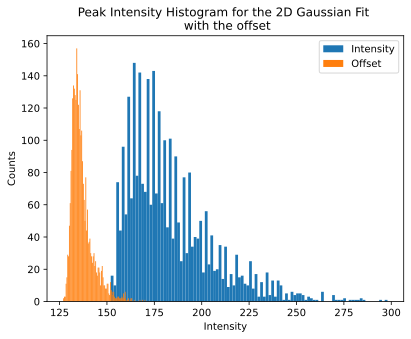

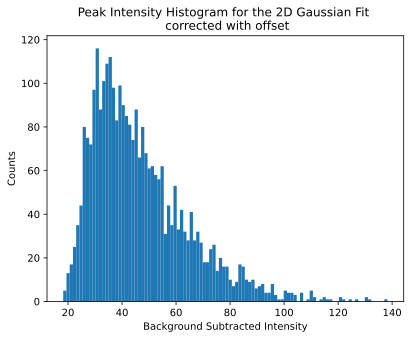

In [12]:
#plot the histrogram of the intensity alongside the offset and label them
plt.hist(df_fit['I'],bins=100)
plt.hist(df_fit['offset'],bins=100)
plt.legend(['Intensity','Offset'])
plt.xlabel('Intensity')
plt.ylabel('Counts')
plt.title('Peak Intensity Histogram for the 2D Gaussian Fit \n with the offset')
plt.show()

#replot the histogram after subtracting the offset
plt.hist(df_fit['I']-df_fit['offset'],bins=100)
plt.xlabel('Background Subtracted Intensity')
plt.ylabel('Counts')
plt.title('Peak Intensity Histogram for the 2D Gaussian Fit \n corrected with offset')
plt.show()




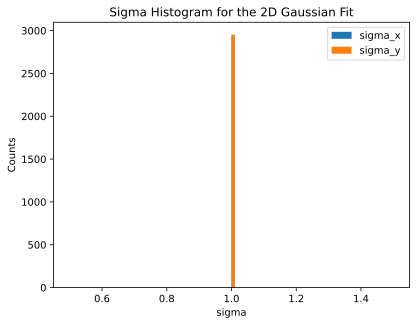

In [13]:
#plot the historgram of the sigma_x and sigma_y values
plt.hist(df_fit['sigma_x'],bins=100)
plt.hist(df_fit['sigma_y'],bins=100)
plt.legend(['sigma_x','sigma_y'])
plt.xlabel('sigma')
plt.ylabel('Counts')
plt.title('Sigma Histogram for the 2D Gaussian Fit')
plt.show()


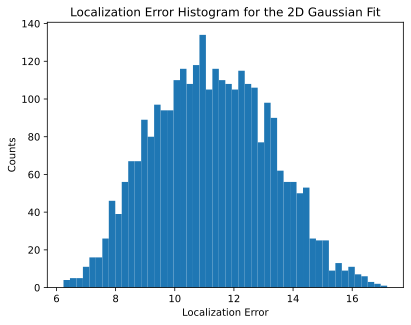

In [14]:
#find the localization error using the follow formula: loc_err = sqrt(sigma_x^2 + sigma_y^2)/(sqrt((I-offset)*2*pi))
#store the localization error in a new column in the dataframe
#one pixel is 130 nm so the localization error is in nm
df_fit['loc_err'] = np.sqrt(df_fit['sigma_x']**2 + df_fit['sigma_y']**2)/(np.sqrt((df_fit['I']-df_fit['offset'])*2*np.pi))*130
#plot the histogram of the localization error
plt.hist(df_fit['loc_err'],bins=50)
plt.xlabel('Localization Error')
plt.ylabel('Counts')
plt.title('Localization Error Histogram for the 2D Gaussian Fit')
plt.show()


100.0
{'Fitted': array([], shape=(0, 4), dtype=float64), 'Scale': array([], shape=(0, 3), dtype=float64), 'Fit': array([], shape=(0, 3), dtype=float64)}


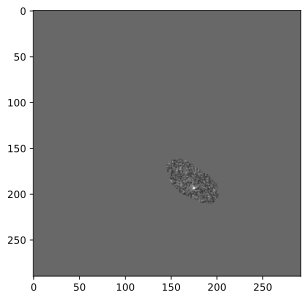

In [37]:
from src.helpers.Analysis_functions import *
from src.helpers.blob_detection import *
#import io from skimage import io
from skimage import io

detection_args = {"median":False,
                "threshold":1e2,
                "min_sigma":1.1/np.sqrt(2),
                "max_sigma":2./np.sqrt(2),
                "num_sigma":200,
                "overlap":0,
                "logscale":False,
                "verbose":True}
fitting_args = {"mask_size":4,
                "plot_fit":False,
                "fitting_image":"Original",
                "radius_func":None,
                "residual_func":residuals_gaus2d,
                "sigma_range":0.5,
                "centeroid_range":0.1}

#get the first frame of the data
frame = data[126,:,:]
#find the blobs in the frame
blob_detector = blob_detection(path=frame,**detection_args)
print(blob_detector.threshold)
blob_detector._update_fitting_parameters(kwargs=fitting_args)
#detect blobs
c = blob_detector.detection(type="bp")

print(c)
#plot the image
plt.imshow(frame,cmap='gray')
plt.show()

In [16]:
#for all images find the blobs and store the data in a dataframe
df_blob = pd.DataFrame(columns=['frame','x','y','I','sigma_x','sigma_y','offset','loc_err'])

for i in range(data.shape[0]):
    if i%1 == 0:
        
        #get the frame
        frame = data[i,:,:]
        #find the blobs in the frame
        blob_detector = blob_detection(path=frame,**detection_args)
        blob_detector._update_fitting_parameters(kwargs=fitting_args)
        #detect blobs
        c = blob_detector.detection(type="bp")
        print("performing blob detection on frame: ",i)
        print("found ",len(c["Fit"])," blobs")
        for j in c["Fit"]:

            I = j.params["height"].value
            x = j.params["centroid_x"].value
            y = j.params["centroid_y"].value
            sigma_x = j.params["sigma_x"].value
            sigma_y = j.params["sigma_y"].value
            offset = j.params["background"].value
            loc_err = 130*np.sqrt(sigma_x**2 + sigma_y**2)/(np.sqrt((I)*2*np.pi))
            df_blob = pd.concat([df_blob,pd.DataFrame([[i,x,y,I,sigma_x,sigma_y,offset,loc_err]],columns=['frame','x','y','I','sigma_x','sigma_y','offset','loc_err'])])

        


performing blob detection on frame:  0
found  1  blobs
performing blob detection on frame:  1
found  0  blobs
performing blob detection on frame:  2
found  0  blobs
performing blob detection on frame:  3
found  1  blobs
performing blob detection on frame:  4
found  0  blobs
performing blob detection on frame:  5
found  0  blobs
performing blob detection on frame:  6
found  1  blobs
performing blob detection on frame:  7
found  0  blobs
performing blob detection on frame:  8
found  1  blobs
performing blob detection on frame:  9
found  0  blobs
performing blob detection on frame:  10
found  0  blobs
performing blob detection on frame:  11
found  1  blobs
performing blob detection on frame:  12
found  1  blobs
performing blob detection on frame:  13
found  0  blobs
performing blob detection on frame:  14
found  0  blobs
performing blob detection on frame:  15
found  1  blobs
performing blob detection on frame:  16
found  0  blobs
performing blob detection on frame:  17
found  1  blobs
pe

KeyboardInterrupt: 

In [ ]:
#plot the histogram of the localization error
plt.hist(df_blob['loc_err'].values,bins=50)
plt.xlabel('Localization Error')
plt.ylabel('Counts')
plt.title('Localization Error Histogram for the Blob Detection')
plt.show()

#plot the histogram of the intensity
plt.hist(df_blob['I'].values,bins=50)
plt.xlabel('Intensity')
plt.ylabel('Counts')
plt.title('Intensity Histogram for the Blob Detection')
plt.show()


In [38]:
#for all images find the blobs and store the data in a dataframe
df_blob = pd.DataFrame(columns=['frame','x','y','I','sigma_x','sigma_y','offset','loc_err'])

#read in a tiff stack
data_nM = io.imread("/Volumes/Baljyot_HD/Sim_Data/sim_data/h_0_track_500_diff_0_at_100100/test_seg.tiff")
data_nM = data_nM.astype(np.float64)


for i in range(data_nM.shape[0]):
    if i%1 == 0:
        
        #get the frame
        frame = data_nM[i,:,:]
        #find the blobs in the frame
        blob_detector = blob_detection(path=frame,**detection_args)
        blob_detector._update_fitting_parameters(kwargs=fitting_args)
        #detect blobs
        c = blob_detector.detection(type="bp")
        print("performing blob detection on frame: ",i)
        print("found ",len(c["Fit"])," blobs")
        for j in c["Fit"]:

            I = j.params["height"].value
            x = j.params["centroid_x"].value
            y = j.params["centroid_y"].value
            sigma_x = j.params["sigma_x"].value
            sigma_y = j.params["sigma_y"].value
            offset = j.params["background"].value
            loc_err = 130*np.sqrt(sigma_x**2 + sigma_y**2)/(np.sqrt((I)*2*np.pi))
            df_blob = pd.concat([df_blob,pd.DataFrame([[i,x,y,I,sigma_x,sigma_y,offset,loc_err]],columns=['frame','x','y','I','sigma_x','sigma_y','offset','loc_err'])])


performing blob detection on frame:  0
found  1  blobs
performing blob detection on frame:  1
found  1  blobs
performing blob detection on frame:  2
found  1  blobs
performing blob detection on frame:  3
found  1  blobs
performing blob detection on frame:  4
found  1  blobs
performing blob detection on frame:  5
found  1  blobs
performing blob detection on frame:  6
found  1  blobs
performing blob detection on frame:  7
found  1  blobs
performing blob detection on frame:  8
found  1  blobs
performing blob detection on frame:  9
found  1  blobs
performing blob detection on frame:  10
found  1  blobs
performing blob detection on frame:  11
found  1  blobs
performing blob detection on frame:  12
found  1  blobs
performing blob detection on frame:  13
found  1  blobs
performing blob detection on frame:  14
found  1  blobs
performing blob detection on frame:  15
found  1  blobs
performing blob detection on frame:  16
found  1  blobs
performing blob detection on frame:  17
found  1  blobs
pe

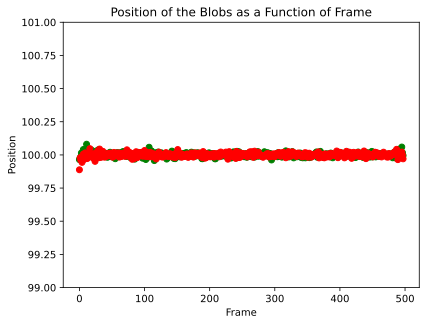

In [54]:
#plot the x positions of the blobs as a function of frame
plt.scatter(df_blob['frame'].values,df_blob['x'].values,color='green')
#and the y positions
plt.scatter(df_blob['frame'].values,df_blob['y'].values,color='red')
plt.xlabel('Frame')
plt.ylabel('Position')
plt.title('Position of the Blobs as a Function of Frame')
plt.ylim(99,101)
plt.show()



